# Cambridge Red Line Corridor Analysis
## Part 3: Exploratory Data Analysis

**Objective**: Conduct comprehensive exploratory analysis to understand market patterns, trends, and relationships in the Cambridge corridor data.

**Key Analysis Areas**:
- Property value distributions and trends
- Market composition by Red Line squares
- Price per square foot analysis
- Building age and vintage patterns
- Transit accessibility impact
- Property type and zoning insights
- Investment opportunity indicators

**Input**: Clean datasets from Part 2
**Output**: Comprehensive market insights and visualizations

---

In [ ]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
from pathlib import Path
from scipy import stats
from scipy.stats import pearsonr, spearmanr
import folium
from folium.plugins import HeatMap

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Set up file paths
PROJECT_ROOT = Path('../')
DATA_PROCESSED = PROJECT_ROOT / 'data' / 'processed'
CLEAN_DATA = DATA_PROCESSED / 'clean'
OUTPUT_DIR = PROJECT_ROOT / 'output'
PLOTS_DIR = OUTPUT_DIR / 'plots'
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

print("Cambridge Corridor Analysis - Exploratory Data Analysis")
print("=" * 60)
print("Libraries loaded successfully")
print("File paths configured")
print("Ready for exploratory analysis")

Cambridge Corridor Analysis - Exploratory Data Analysis
✓ Libraries loaded successfully
✓ File paths configured
✓ Ready for exploratory analysis


## Load Clean Datasets

Load the cleaned and processed datasets from Part 2.

In [ ]:
# Load Clean Datasets with Actual Assessed Values
print("Output 1: Loading Clean Datasets with Cambridge Assessment Data")
print("=========================")

# Load the datasets created by our updated pipeline
CLEAN_DATA = PROJECT_ROOT / 'data' / 'processed'

# Try to load corridor properties with assessed values
corridor_file = CLEAN_DATA / 'corridor_properties_clean.csv'
if corridor_file.exists():
    df_corridor = pd.read_csv(corridor_file)
    print(f"Corridor properties: {len(df_corridor):,} records")
else:
    # Load from standardized dataset and filter
    standardized_file = CLEAN_DATA / 'cambridge_properties_standardized.csv'
    if standardized_file.exists():
        df_all = pd.read_csv(standardized_file)
        # Filter for Mass Ave corridor (approximate bounds)
        corridor_mask = (
            (df_all['LATITUDE'].between(42.35, 42.40)) & 
            (df_all['LONGITUDE'].between(-71.13, -71.10))
        )
        df_corridor = df_all[corridor_mask].copy()
        print(f"Corridor properties (filtered from standardized): {len(df_corridor):,} records")
    else:
        print("WARNING: No standardized dataset found. Please run data acquisition first.")
        df_corridor = pd.DataFrame()

# Load commercial and Mass Ave specific datasets or create from corridor data
if len(df_corridor) > 0:
    # Create commercial subset
    commercial_mask = df_corridor['GENERAL_USE_CATEGORY'] == 'Commercial'
    df_commercial = df_corridor[commercial_mask].copy()
    
    # Create Mass Ave specific subset (properties very close to Mass Ave)
    # This is a simplified approach - you might want more precise filtering
    mass_ave_mask = (
        (df_corridor['LATITUDE'].between(42.365, 42.395)) & 
        (df_corridor['LONGITUDE'].between(-71.125, -71.105))
    )
    df_mass_ave = df_corridor[mass_ave_mask].copy()
    
    print(f"Commercial properties: {len(df_commercial):,} records")
    print(f"Mass Ave properties: {len(df_mass_ave):,} records")
else:
    df_commercial = pd.DataFrame()
    df_mass_ave = pd.DataFrame()

print(f"\nDataset Overview:")
print(f"--------------------")
print(f"Total properties: {len(df_corridor):,}")
print(f"Commercial share: {len(df_commercial)/len(df_corridor)*100:.1f}%" if len(df_corridor) > 0 else "Commercial share: 0%")
print(f"Mass Ave share: {len(df_mass_ave)/len(df_corridor)*100:.1f}%" if len(df_corridor) > 0 else "Mass Ave share: 0%")

if len(df_corridor) > 0:
    available_features = df_corridor.columns.tolist()
    print(f"Available features: {len(available_features)}")
    
    print(f"\nAvailable columns in Cambridge assessment data:")
    key_features = ['PROPERTY_ID', 'ADDRESS', 'TOTAL_VALUE', 'LAND_VALUE', 'BUILDING_VALUE', 
                   'GROSS_AREA', 'PRICE_PER_SQFT', 'YEAR_BUILT', 'BUILDING_AGE', 'PROPERTY_TYPE']
    available_key_features = [col for col in key_features if col in df_corridor.columns]
    
    print(f"Key assessment columns: {available_key_features}")
    print(f"Columns: {available_features}")
    
    # Show sample with actual assessment data
    print(f"\nFirst 3 records (corridor dataset) - with assessed values:")
    display_cols = ['ADDRESS', 'TOTAL_VALUE', 'LAND_VALUE', 'BUILDING_VALUE', 'GROSS_AREA', 'PRICE_PER_SQFT']
    available_display_cols = [col for col in display_cols if col in df_corridor.columns]
    
    if available_display_cols:
        print(df_corridor[available_display_cols].head(3).to_string())
    else:
        print(df_corridor.head(3).to_string())
    
    # Data quality for key fields
    print(f"\nData types and key field coverage:")
    for col in available_key_features:
        if col in df_corridor.columns:
            non_null_count = df_corridor[col].notna().sum()
            pct = (non_null_count / len(df_corridor)) * 100
            print(f"  {col}: {non_null_count:,} non-null ({pct:.1f}%)")
else:
    print("No data available for analysis.")

Output 1: Loading Clean Datasets with Cambridge Assessment Data
✓ Corridor properties (filtered from standardized): 16,540 records
✓ Commercial properties: 210 records
✓ Mass Ave properties: 8,851 records

Dataset Overview:
--------------------
Total properties: 16,540
Commercial share: 1.3%
Mass Ave share: 53.5%
Available features: 30

Available columns in Cambridge assessment data:
Key assessment columns: ['PROPERTY_ID', 'ADDRESS', 'TOTAL_VALUE', 'LAND_VALUE', 'BUILDING_VALUE', 'GROSS_AREA', 'PRICE_PER_SQFT', 'YEAR_BUILT', 'BUILDING_AGE', 'PROPERTY_TYPE']
Columns: ['PROPERTY_ID', 'ADDRESS', 'PROPERTY_TYPE', 'MAP_LOT', 'LATITUDE', 'LONGITUDE', 'LOT_SIZE', 'TOTAL_VALUE', 'LAND_VALUE', 'BUILDING_VALUE', 'GROSS_AREA', 'YEAR_BUILT', 'USE_CODE', 'ZONING', 'ASSESSMENT_YEAR', 'SALE_PRICE', 'SALE_DATE', 'OWNER_NAME', 'TOTAL_ROOMS', 'BEDROOMS', 'GARAGE_SPACES', 'BUILDING_AGE', 'PRICE_PER_SQFT', 'VALUE_CATEGORY', 'SIZE_CATEGORY', 'GENERAL_USE_CATEGORY', 'NEIGHBORHOOD', 'NEIGHBORHOOD_DENSITY', '

## Market Overview and Summary Statistics

High-level analysis of the Cambridge corridor real estate market.

In [24]:
# Cambridge Market Overview with Assessed Values
print("CAMBRIDGE CORRIDOR MARKET OVERVIEW")
print("=" * 40)

# Check what columns we actually have
if len(df_corridor) > 0:
    available_cols = df_corridor.columns.tolist()
    print(f"Working with {len(available_cols)} available data columns")
    
    # Key market metrics using available Cambridge assessment data
    market_metrics = {
        'Total Properties': len(df_corridor),
        'Commercial Properties': len(df_commercial),
    }
    
    # Add metrics based on available columns
    if 'TOTAL_VALUE' in df_corridor.columns:
        total_market_value = df_corridor['TOTAL_VALUE'].sum()
        avg_value = df_corridor['TOTAL_VALUE'].mean()
        median_value = df_corridor['TOTAL_VALUE'].median()
        
        market_metrics.update({
            'Total Market Value': total_market_value,
            'Average Property Value': avg_value,
            'Median Property Value': median_value,
        })
    
    if 'LOT_SIZE' in df_corridor.columns:
        market_metrics.update({
            'Total Land Area (sq ft)': df_corridor['LOT_SIZE'].sum(),
            'Average Lot Size (sq ft)': df_corridor['LOT_SIZE'].mean(),
            'Median Lot Size (sq ft)': df_corridor['LOT_SIZE'].median(),
            'Lot Size Range (sq ft)': f"{df_corridor['LOT_SIZE'].min():,.0f} - {df_corridor['LOT_SIZE'].max():,.0f}",
        })
    
    if 'PRICE_PER_SQFT' in df_corridor.columns:
        market_metrics.update({
            'Average Price/Sq Ft': df_corridor['PRICE_PER_SQFT'].mean(),
            'Median Price/Sq Ft': df_corridor['PRICE_PER_SQFT'].median(),
        })
    
    if 'BUILDING_AGE' in df_corridor.columns:
        market_metrics['Average Building Age'] = df_corridor['BUILDING_AGE'].mean()
    
    if 'PROPERTY_TYPE' in df_corridor.columns:
        market_metrics['Property Types'] = df_corridor['PROPERTY_TYPE'].nunique()
    
    # Display metrics
    for metric, value in market_metrics.items():
        if isinstance(value, (int, float)) and ('Value' in metric or 'Market' in metric):
            print(f"{metric}: ${value:,.0f}")
        elif isinstance(value, (int, float)) and 'Price' in metric:
            print(f"{metric}: ${value:.0f}")
        elif isinstance(value, (int, float)) and 'Area' in metric:
            print(f"{metric}: {value:,.0f}")
        elif isinstance(value, (int, float)):
            print(f"{metric}: {value:,.1f}")
        else:
            print(f"{metric}: {value}")

    # Property type distribution
    if 'PROPERTY_TYPE' in df_corridor.columns:
        print("\nPROPERTY TYPE DISTRIBUTION:")
        print("-" * 30)
        type_dist = df_corridor['PROPERTY_TYPE'].value_counts()
        type_pct = (type_dist / len(df_corridor) * 100).round(1)
        type_summary = pd.DataFrame({
            'Count': type_dist,
            'Percentage': type_pct
        })
        print(type_summary.head(10))  # Show top 10 types

    # Value category analysis (if we have assessed values)
    if 'VALUE_CATEGORY' in df_corridor.columns and 'TOTAL_VALUE' in df_corridor.columns:
        print("\nVALUE CATEGORY ANALYSIS:")
        print("-" * 25)
        value_cat_summary = df_corridor.groupby('VALUE_CATEGORY').agg({
            'PROPERTY_ID': 'count',
            'TOTAL_VALUE': ['mean', 'median'],
            'LOT_SIZE': 'mean' if 'LOT_SIZE' in df_corridor.columns else lambda x: 0
        }).round(0)
        print(value_cat_summary)

    # General use category analysis
    if 'GENERAL_USE_CATEGORY' in df_corridor.columns:
        print("\nGENERAL USE CATEGORY ANALYSIS:")
        print("-" * 32)
        
        agg_dict = {'PROPERTY_ID': 'count'}
        if 'TOTAL_VALUE' in df_corridor.columns:
            agg_dict['TOTAL_VALUE'] = ['mean', 'median']
        if 'LOT_SIZE' in df_corridor.columns:
            agg_dict['LOT_SIZE'] = ['mean', 'median']
            
        use_cat_summary = df_corridor.groupby('GENERAL_USE_CATEGORY').agg(agg_dict).round(2)
        print(use_cat_summary)

else:
    print("No data available for market analysis.")

CAMBRIDGE CORRIDOR MARKET OVERVIEW
Working with 30 available data columns
Total Properties: 16,540.0
Commercial Properties: 210.0
Total Market Value: $179,807,719,462
Average Property Value: $12,121,324
Median Property Value: $1,034,850
Total Land Area (sq ft): 195497441
Average Lot Size (sq ft): 11,819.7
Median Lot Size (sq ft): 0.0
Lot Size Range (sq ft): 0 - 4,825,926
Average Price/Sq Ft: $869
Median Price/Sq Ft: $814
Average Building Age: 339.0
Property Types: 96.0

PROPERTY TYPE DISTRIBUTION:
------------------------------
                             Count  Percentage
PROPERTY_TYPE                                 
CONDOMINIUM                   8615        52.1
SNGL-FAM-RES                  1810        10.9
CONDO-BLDG                    1706        10.3
TWO-FAM-RES                   1033         6.2
THREE-FM-RES                   643         3.9
CNDO LUX                       397         2.4
Private College, University    357         2.2
4-8-UNIT-APT                   282         

## Property Value Analysis

Deep dive into property value patterns and distributions across the corridor.

Property Value Analysis
Available columns for analysis: 30
✓ Value range: $0 - $1,595,368,600


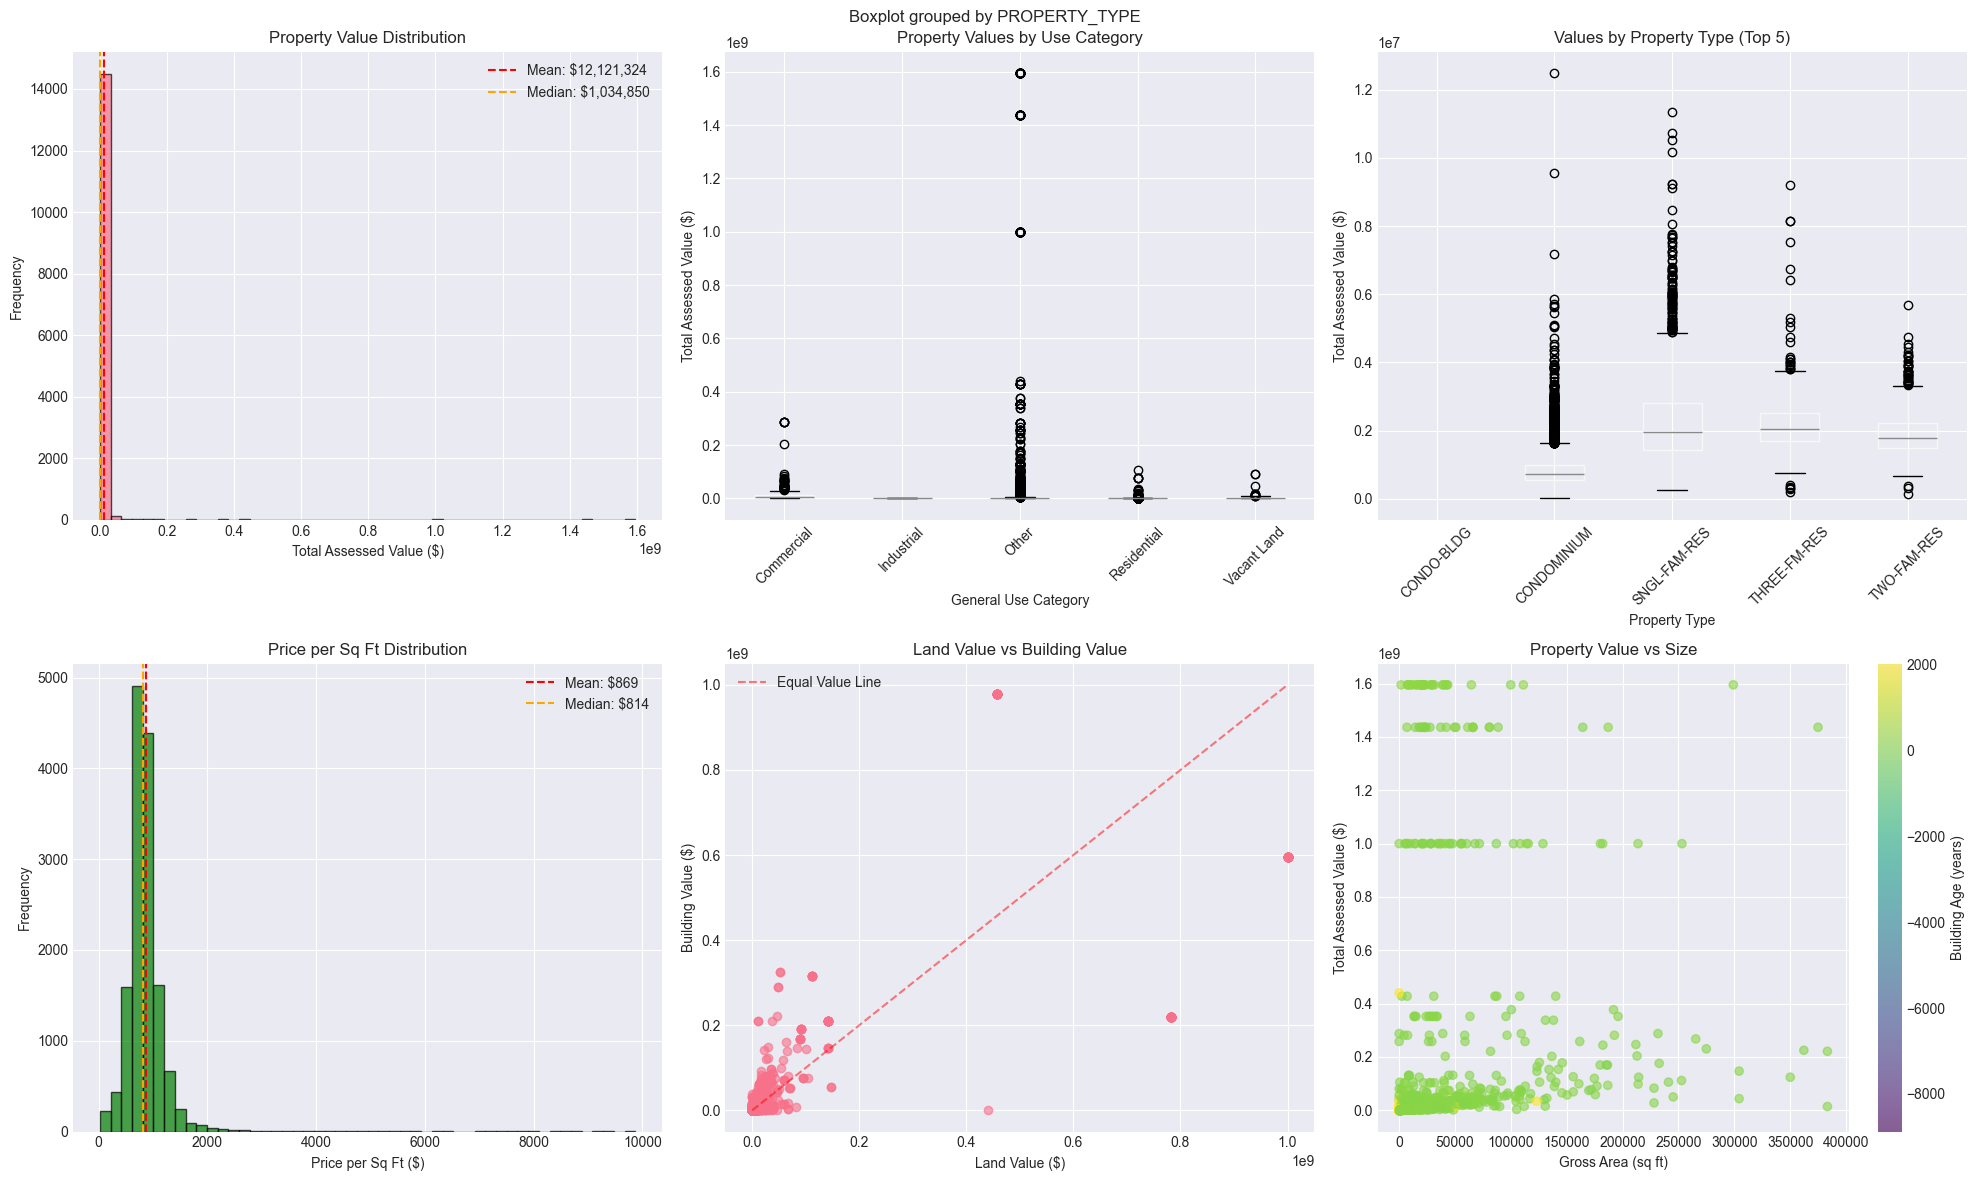

Property value analysis completed with available real assessment data!


In [ ]:
# Property Value Analysis with Real Assessment Data
print("Property Value Analysis")
print("=" * 25)

# Check available columns first
available_cols = df_corridor.columns.tolist()
print(f"Available columns for analysis: {len(available_cols)}")

# Create comprehensive value analysis plots
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Cambridge Corridor - Property Value Analysis (Real Assessment Data)', fontsize=16, fontweight='bold')

# 1. Value distribution histogram
if 'TOTAL_VALUE' in df_corridor.columns:
    valid_values = df_corridor['TOTAL_VALUE'].dropna()
    axes[0,0].hist(valid_values, bins=50, alpha=0.7, edgecolor='black')
    axes[0,0].axvline(valid_values.mean(), color='red', linestyle='--', 
                      label=f'Mean: ${valid_values.mean():,.0f}')
    axes[0,0].axvline(valid_values.median(), color='orange', linestyle='--', 
                      label=f'Median: ${valid_values.median():,.0f}')
    axes[0,0].set_title('Property Value Distribution')
    axes[0,0].set_xlabel('Total Assessed Value ($)')
    axes[0,0].set_ylabel('Frequency')
    axes[0,0].legend()
    print(f"Value range: ${valid_values.min():,.0f} - ${valid_values.max():,.0f}")

# 2. Value by general use category (since we don't have CORRIDOR_SEGMENT)
if 'GENERAL_USE_CATEGORY' in df_corridor.columns and 'TOTAL_VALUE' in df_corridor.columns:
    df_corridor.boxplot(column='TOTAL_VALUE', by='GENERAL_USE_CATEGORY', ax=axes[0,1])
    axes[0,1].set_title('Property Values by Use Category')
    axes[0,1].set_xlabel('General Use Category')
    axes[0,1].set_ylabel('Total Assessed Value ($)')
    axes[0,1].tick_params(axis='x', rotation=45)
else:
    axes[0,1].text(0.5, 0.5, 'Use Category data not available', ha='center', va='center')
    axes[0,1].set_title('Property Values by Use Category (N/A)')

# 3. Value by property type (top types only)
if 'PROPERTY_TYPE' in df_corridor.columns and 'TOTAL_VALUE' in df_corridor.columns:
    # Get top 5 most common property types
    top_types = df_corridor['PROPERTY_TYPE'].value_counts().head(5).index
    df_top_types = df_corridor[df_corridor['PROPERTY_TYPE'].isin(top_types)]
    
    df_top_types.boxplot(column='TOTAL_VALUE', by='PROPERTY_TYPE', ax=axes[0,2])
    axes[0,2].set_title('Values by Property Type (Top 5)')
    axes[0,2].set_xlabel('Property Type')
    axes[0,2].set_ylabel('Total Assessed Value ($)')
    axes[0,2].tick_params(axis='x', rotation=45)
else:
    axes[0,2].text(0.5, 0.5, 'Property type data not available', ha='center', va='center')
    axes[0,2].set_title('Values by Property Type (N/A)')

# 4. Price per sq ft distribution
if 'PRICE_PER_SQFT' in df_corridor.columns:
    valid_psf = df_corridor['PRICE_PER_SQFT'].dropna()
    if len(valid_psf) > 0:
        axes[1,0].hist(valid_psf, bins=50, alpha=0.7, edgecolor='black', color='green')
        axes[1,0].axvline(valid_psf.mean(), color='red', linestyle='--', 
                          label=f'Mean: ${valid_psf.mean():.0f}')
        axes[1,0].axvline(valid_psf.median(), color='orange', linestyle='--', 
                          label=f'Median: ${valid_psf.median():.0f}')
        axes[1,0].set_title('Price per Sq Ft Distribution')
        axes[1,0].set_xlabel('Price per Sq Ft ($)')
        axes[1,0].set_ylabel('Frequency')
        axes[1,0].legend()
    else:
        axes[1,0].text(0.5, 0.5, 'No valid price/sqft data', ha='center', va='center')
        axes[1,0].set_title('Price per Sq Ft (No Data)')
else:
    axes[1,0].text(0.5, 0.5, 'Price/sqft data not available', ha='center', va='center')
    axes[1,0].set_title('Price per Sq Ft (N/A)')

# 5. Land value vs building value
if 'LAND_VALUE' in df_corridor.columns and 'BUILDING_VALUE' in df_corridor.columns:
    valid_data = df_corridor[['LAND_VALUE', 'BUILDING_VALUE']].dropna()
    if len(valid_data) > 0:
        scatter = axes[1,1].scatter(valid_data['LAND_VALUE'], valid_data['BUILDING_VALUE'], alpha=0.6)
        axes[1,1].set_title('Land Value vs Building Value')
        axes[1,1].set_xlabel('Land Value ($)')
        axes[1,1].set_ylabel('Building Value ($)')
        
        # Add diagonal line for reference
        max_val = max(valid_data['LAND_VALUE'].max(), valid_data['BUILDING_VALUE'].max())
        axes[1,1].plot([0, max_val], [0, max_val], 'r--', alpha=0.5, label='Equal Value Line')
        axes[1,1].legend()
    else:
        axes[1,1].text(0.5, 0.5, 'No valid land/building data', ha='center', va='center')
        axes[1,1].set_title('Land vs Building Value (No Data)')
else:
    axes[1,1].text(0.5, 0.5, 'Land/building value data not available', ha='center', va='center')
    axes[1,1].set_title('Land vs Building Value (N/A)')

# 6. Value vs Size scatter (if we have area data)
if 'GROSS_AREA' in df_corridor.columns and 'TOTAL_VALUE' in df_corridor.columns:
    valid_data = df_corridor[['GROSS_AREA', 'TOTAL_VALUE']].dropna()
    if len(valid_data) > 0:
        if 'BUILDING_AGE' in df_corridor.columns:
            # Color by building age if available
            age_data = df_corridor.loc[valid_data.index, 'BUILDING_AGE']
            scatter = axes[1,2].scatter(valid_data['GROSS_AREA'], valid_data['TOTAL_VALUE'], 
                                       c=age_data, cmap='viridis', alpha=0.6)
            plt.colorbar(scatter, ax=axes[1,2], label='Building Age (years)')
        else:
            # Simple scatter without color coding
            axes[1,2].scatter(valid_data['GROSS_AREA'], valid_data['TOTAL_VALUE'], alpha=0.6)
        
        axes[1,2].set_title('Property Value vs Size')
        axes[1,2].set_xlabel('Gross Area (sq ft)')
        axes[1,2].set_ylabel('Total Assessed Value ($)')
    else:
        axes[1,2].text(0.5, 0.5, 'No valid area/value data', ha='center', va='center')
        axes[1,2].set_title('Value vs Size (No Data)')
else:
    axes[1,2].text(0.5, 0.5, 'Area/value data not available', ha='center', va='center')
    axes[1,2].set_title('Value vs Size (N/A)')

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'property_value_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Property value analysis completed with available real assessment data!")

## Building Age and Vintage Analysis

Examine building age patterns and their impact on property values.

Building Age and Vintage Analysis
Properties with valid building year data: 14,494
Year range: 1800 - 2022
Age range: 2 - 224 years

Construction by Decade:
              PROPERTY_ID  TOTAL_VALUE  PRICE_PER_SQFT  GROSS_AREA
DECADE_BUILT                                                      
1800                   12    2283958.0           821.0      2908.0
1810                    7    5245057.0           996.0      6444.0
1820                   20  480206920.0           905.0      6626.0
1830                   62  104515448.0           928.0      4699.0
1840                  161  149609821.0           954.0      5697.0
1850                  372   31421938.0           953.0      2997.0
1860                  227   29420270.0           910.0      6051.0
1870                 1016    4375562.0           895.0      2595.0
1880                 1021    4795192.0           890.0      2678.0
1890                 1325    4463204.0           811.0      3104.0
1900                 2620    4575611.0 

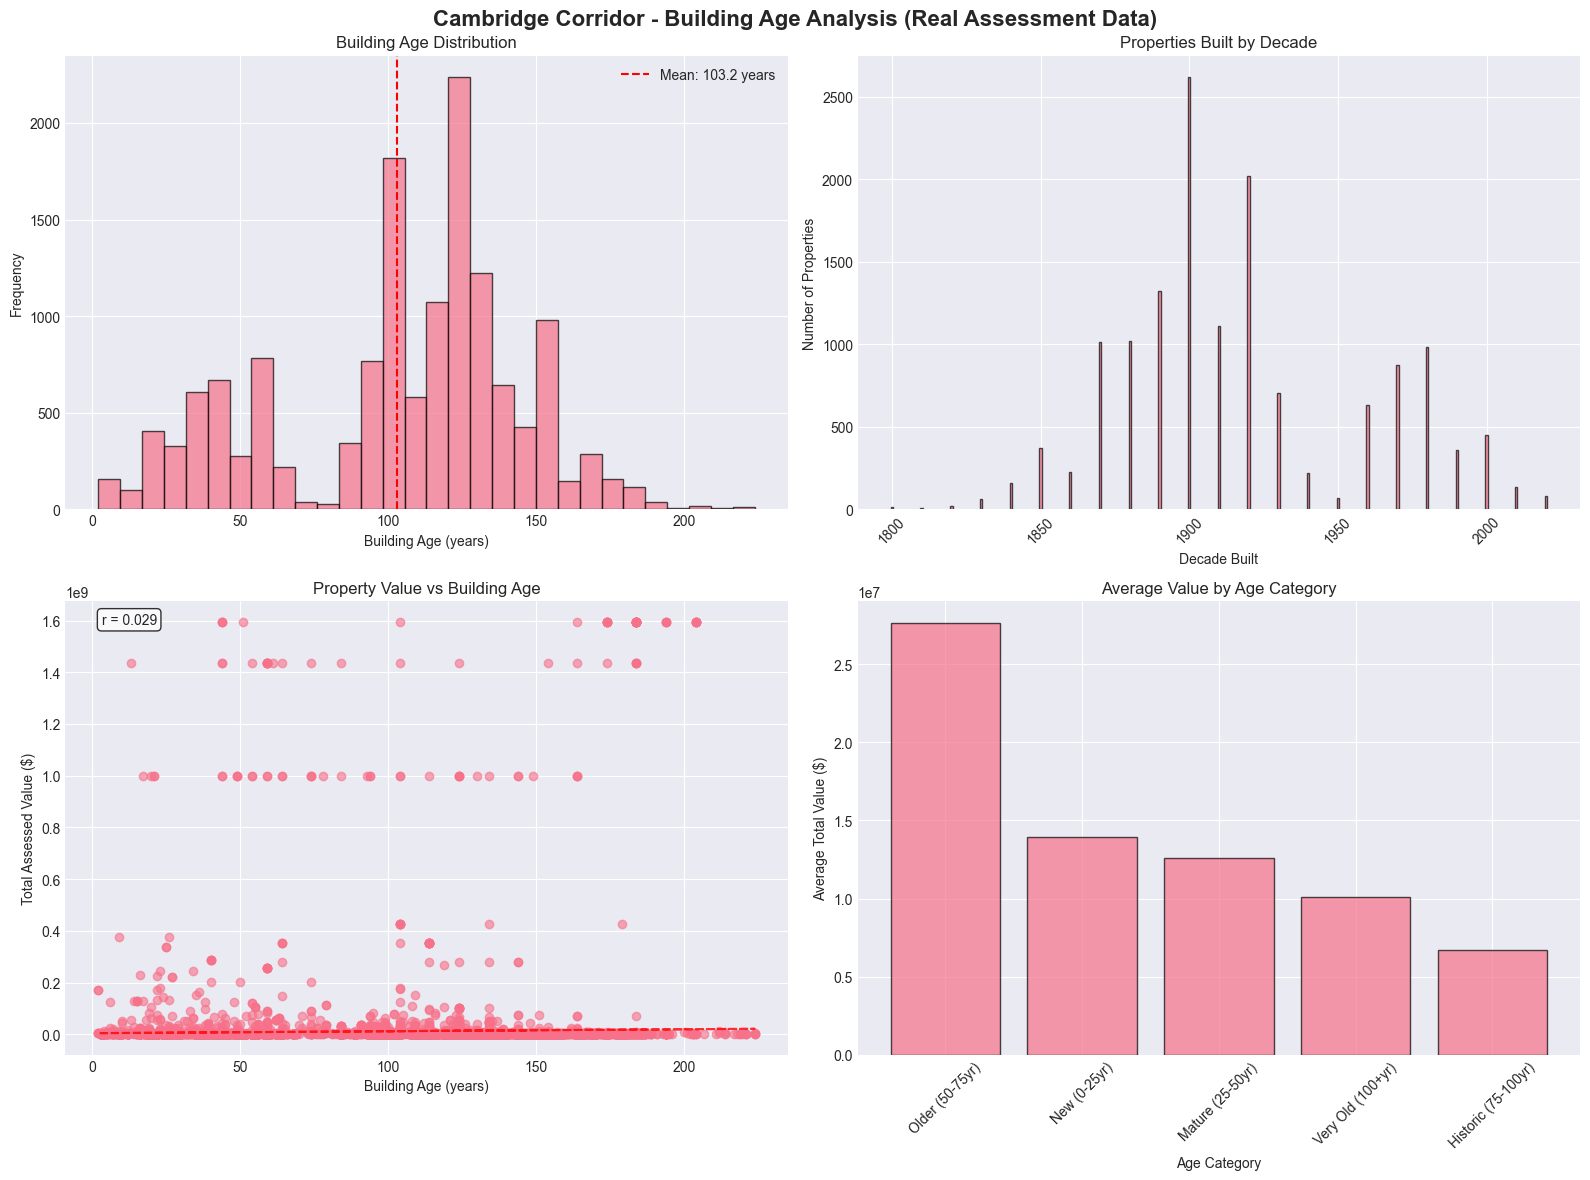


AGE-VALUE CORRELATION:
Building Age vs Total Value: r = 0.029 (p = 0.001)
Building Age vs Price/Sq Ft: r = -0.048 (p = 0.000)

Building age analysis complete!


In [27]:
# Building Age and Vintage Analysis with Real Data
print("Building Age and Vintage Analysis")
print("=" * 35)

# Check if we have building age/year data
if 'YEAR_BUILT' in df_corridor.columns:
    # Filter out invalid years (too old or future)
    valid_year_mask = (df_corridor['YEAR_BUILT'] >= 1800) & (df_corridor['YEAR_BUILT'] <= 2024)
    df_valid_age = df_corridor[valid_year_mask].copy()
    
    if len(df_valid_age) > 0:
        # Calculate building age if not already present
        if 'BUILDING_AGE' not in df_valid_age.columns:
            current_year = 2024
            df_valid_age['BUILDING_AGE'] = current_year - df_valid_age['YEAR_BUILT']
        
        # Age analysis by decade
        df_valid_age['DECADE_BUILT'] = (df_valid_age['YEAR_BUILT'] // 10) * 10
        
        print(f"Properties with valid building year data: {len(df_valid_age):,}")
        print(f"Year range: {df_valid_age['YEAR_BUILT'].min():.0f} - {df_valid_age['YEAR_BUILT'].max():.0f}")
        print(f"Age range: {df_valid_age['BUILDING_AGE'].min():.0f} - {df_valid_age['BUILDING_AGE'].max():.0f} years")
        
        # Aggregate analysis by decade
        agg_cols = {'PROPERTY_ID': 'count'}
        if 'TOTAL_VALUE' in df_valid_age.columns:
            agg_cols['TOTAL_VALUE'] = 'mean'
        if 'PRICE_PER_SQFT' in df_valid_age.columns:
            agg_cols['PRICE_PER_SQFT'] = 'mean'
        if 'GROSS_AREA' in df_valid_age.columns:
            agg_cols['GROSS_AREA'] = 'mean'
            
        decade_analysis = df_valid_age.groupby('DECADE_BUILT').agg(agg_cols).round(0)
        
        print(f"\nConstruction by Decade:")
        print(decade_analysis)
        
        # Create age analysis visualizations
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Cambridge Corridor - Building Age Analysis (Real Assessment Data)', fontsize=16, fontweight='bold')
        
        # 1. Age distribution
        axes[0,0].hist(df_valid_age['BUILDING_AGE'], bins=30, alpha=0.7, edgecolor='black')
        mean_age = df_valid_age['BUILDING_AGE'].mean()
        axes[0,0].axvline(mean_age, color='red', linestyle='--', 
                          label=f'Mean: {mean_age:.1f} years')
        axes[0,0].set_title('Building Age Distribution')
        axes[0,0].set_xlabel('Building Age (years)')
        axes[0,0].set_ylabel('Frequency')
        axes[0,0].legend()
        
        # 2. Construction by decade
        decade_counts = df_valid_age['DECADE_BUILT'].value_counts().sort_index()
        axes[0,1].bar(decade_counts.index, decade_counts.values, alpha=0.7, edgecolor='black')
        axes[0,1].set_title('Properties Built by Decade')
        axes[0,1].set_xlabel('Decade Built')
        axes[0,1].set_ylabel('Number of Properties')
        axes[0,1].tick_params(axis='x', rotation=45)
        
        # 3. Value vs Age relationship (if we have values)
        if 'TOTAL_VALUE' in df_valid_age.columns:
            value_age_data = df_valid_age[['BUILDING_AGE', 'TOTAL_VALUE']].dropna()
            if len(value_age_data) > 0:
                axes[1,0].scatter(value_age_data['BUILDING_AGE'], value_age_data['TOTAL_VALUE'], alpha=0.6)
                # Add trend line
                z = np.polyfit(value_age_data['BUILDING_AGE'], value_age_data['TOTAL_VALUE'], 1)
                p = np.poly1d(z)
                axes[1,0].plot(value_age_data['BUILDING_AGE'], p(value_age_data['BUILDING_AGE']), "r--", alpha=0.8)
                axes[1,0].set_title('Property Value vs Building Age')
                axes[1,0].set_xlabel('Building Age (years)')
                axes[1,0].set_ylabel('Total Assessed Value ($)')
                
                # Calculate and display correlation
                from scipy.stats import pearsonr
                corr, p_val = pearsonr(value_age_data['BUILDING_AGE'], value_age_data['TOTAL_VALUE'])
                axes[1,0].text(0.05, 0.95, f'r = {corr:.3f}', transform=axes[1,0].transAxes, 
                              bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))
            else:
                axes[1,0].text(0.5, 0.5, 'No valid age/value data', ha='center', va='center')
                axes[1,0].set_title('Value vs Age (No Data)')
        else:
            axes[1,0].text(0.5, 0.5, 'Value data not available', ha='center', va='center')
            axes[1,0].set_title('Value vs Age (N/A)')
        
        # 4. Age category analysis (create simple age categories)
        age_bins = [0, 25, 50, 75, 100, 200]
        age_labels = ['New (0-25yr)', 'Mature (25-50yr)', 'Older (50-75yr)', 'Historic (75-100yr)', 'Very Old (100+yr)']
        df_valid_age['AGE_CATEGORY'] = pd.cut(df_valid_age['BUILDING_AGE'], bins=age_bins, labels=age_labels, include_lowest=True)
        
        if 'TOTAL_VALUE' in df_valid_age.columns:
            age_cat_summary = df_valid_age.groupby('AGE_CATEGORY')['TOTAL_VALUE'].mean().dropna().sort_values(ascending=False)
            if len(age_cat_summary) > 0:
                axes[1,1].bar(range(len(age_cat_summary)), age_cat_summary.values, 
                              tick_label=age_cat_summary.index, alpha=0.7, edgecolor='black')
                axes[1,1].set_title('Average Value by Age Category')
                axes[1,1].set_xlabel('Age Category')
                axes[1,1].set_ylabel('Average Total Value ($)')
                axes[1,1].tick_params(axis='x', rotation=45)
            else:
                axes[1,1].text(0.5, 0.5, 'No age category data', ha='center', va='center')
                axes[1,1].set_title('Value by Age Category (No Data)')
        else:
            axes[1,1].text(0.5, 0.5, 'Value data not available', ha='center', va='center')
            axes[1,1].set_title('Value by Age Category (N/A)')
        
        plt.tight_layout()
        plt.savefig(PLOTS_DIR / 'building_age_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Calculate correlations if we have the data
        if 'TOTAL_VALUE' in df_valid_age.columns:
            from scipy.stats import pearsonr
            value_age_data = df_valid_age[['BUILDING_AGE', 'TOTAL_VALUE']].dropna()
            if len(value_age_data) > 10:  # Need sufficient data for correlation
                age_value_corr, age_value_p = pearsonr(value_age_data['BUILDING_AGE'], value_age_data['TOTAL_VALUE'])
                print(f"\nAGE-VALUE CORRELATION:")
                print(f"Building Age vs Total Value: r = {age_value_corr:.3f} (p = {age_value_p:.3f})")
                
                if 'PRICE_PER_SQFT' in df_valid_age.columns:
                    psf_age_data = df_valid_age[['BUILDING_AGE', 'PRICE_PER_SQFT']].dropna()
                    if len(psf_age_data) > 10:
                        age_psf_corr, age_psf_p = pearsonr(psf_age_data['BUILDING_AGE'], psf_age_data['PRICE_PER_SQFT'])
                        print(f"Building Age vs Price/Sq Ft: r = {age_psf_corr:.3f} (p = {age_psf_p:.3f})")
        
        print("\nBuilding age analysis complete!")
        
    else:
        print("No properties with valid building year data found.")
        
else:
    print("Building year data not available in dataset.")

## Correlation Analysis and Feature Relationships

Examine relationships between key variables to identify important patterns and drivers.

Correlation Analysis and Feature Relationships
Analyzing correlations for 7 features...


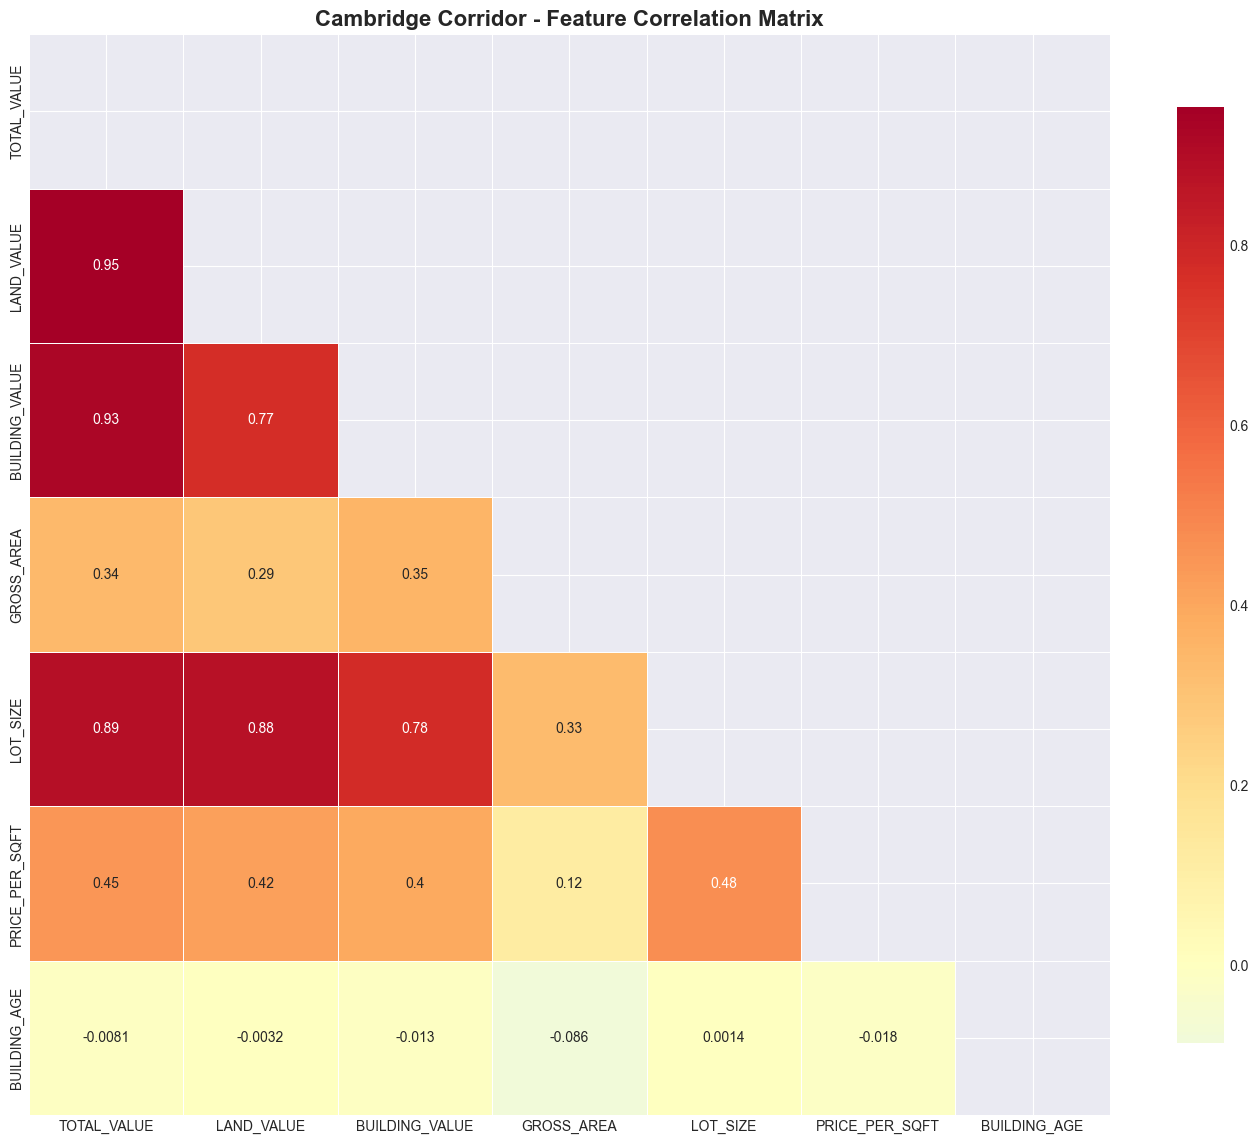


STRONGEST CORRELATIONS WITH PROPERTY VALUE:
---------------------------------------------
LAND_VALUE: 0.954 (positive)
BUILDING_VALUE: 0.925 (positive)
LOT_SIZE: 0.886 (positive)
PRICE_PER_SQFT: 0.452 (positive)
GROSS_AREA: 0.338 (positive)
BUILDING_AGE: 0.008 (negative)

STRONGEST CORRELATIONS WITH PRICE PER SQ FT:
----------------------------------------
LOT_SIZE: 0.477 (positive)
TOTAL_VALUE: 0.452 (positive)
LAND_VALUE: 0.424 (positive)
BUILDING_VALUE: 0.396 (positive)
GROSS_AREA: 0.116 (positive)
BUILDING_AGE: 0.018 (negative)


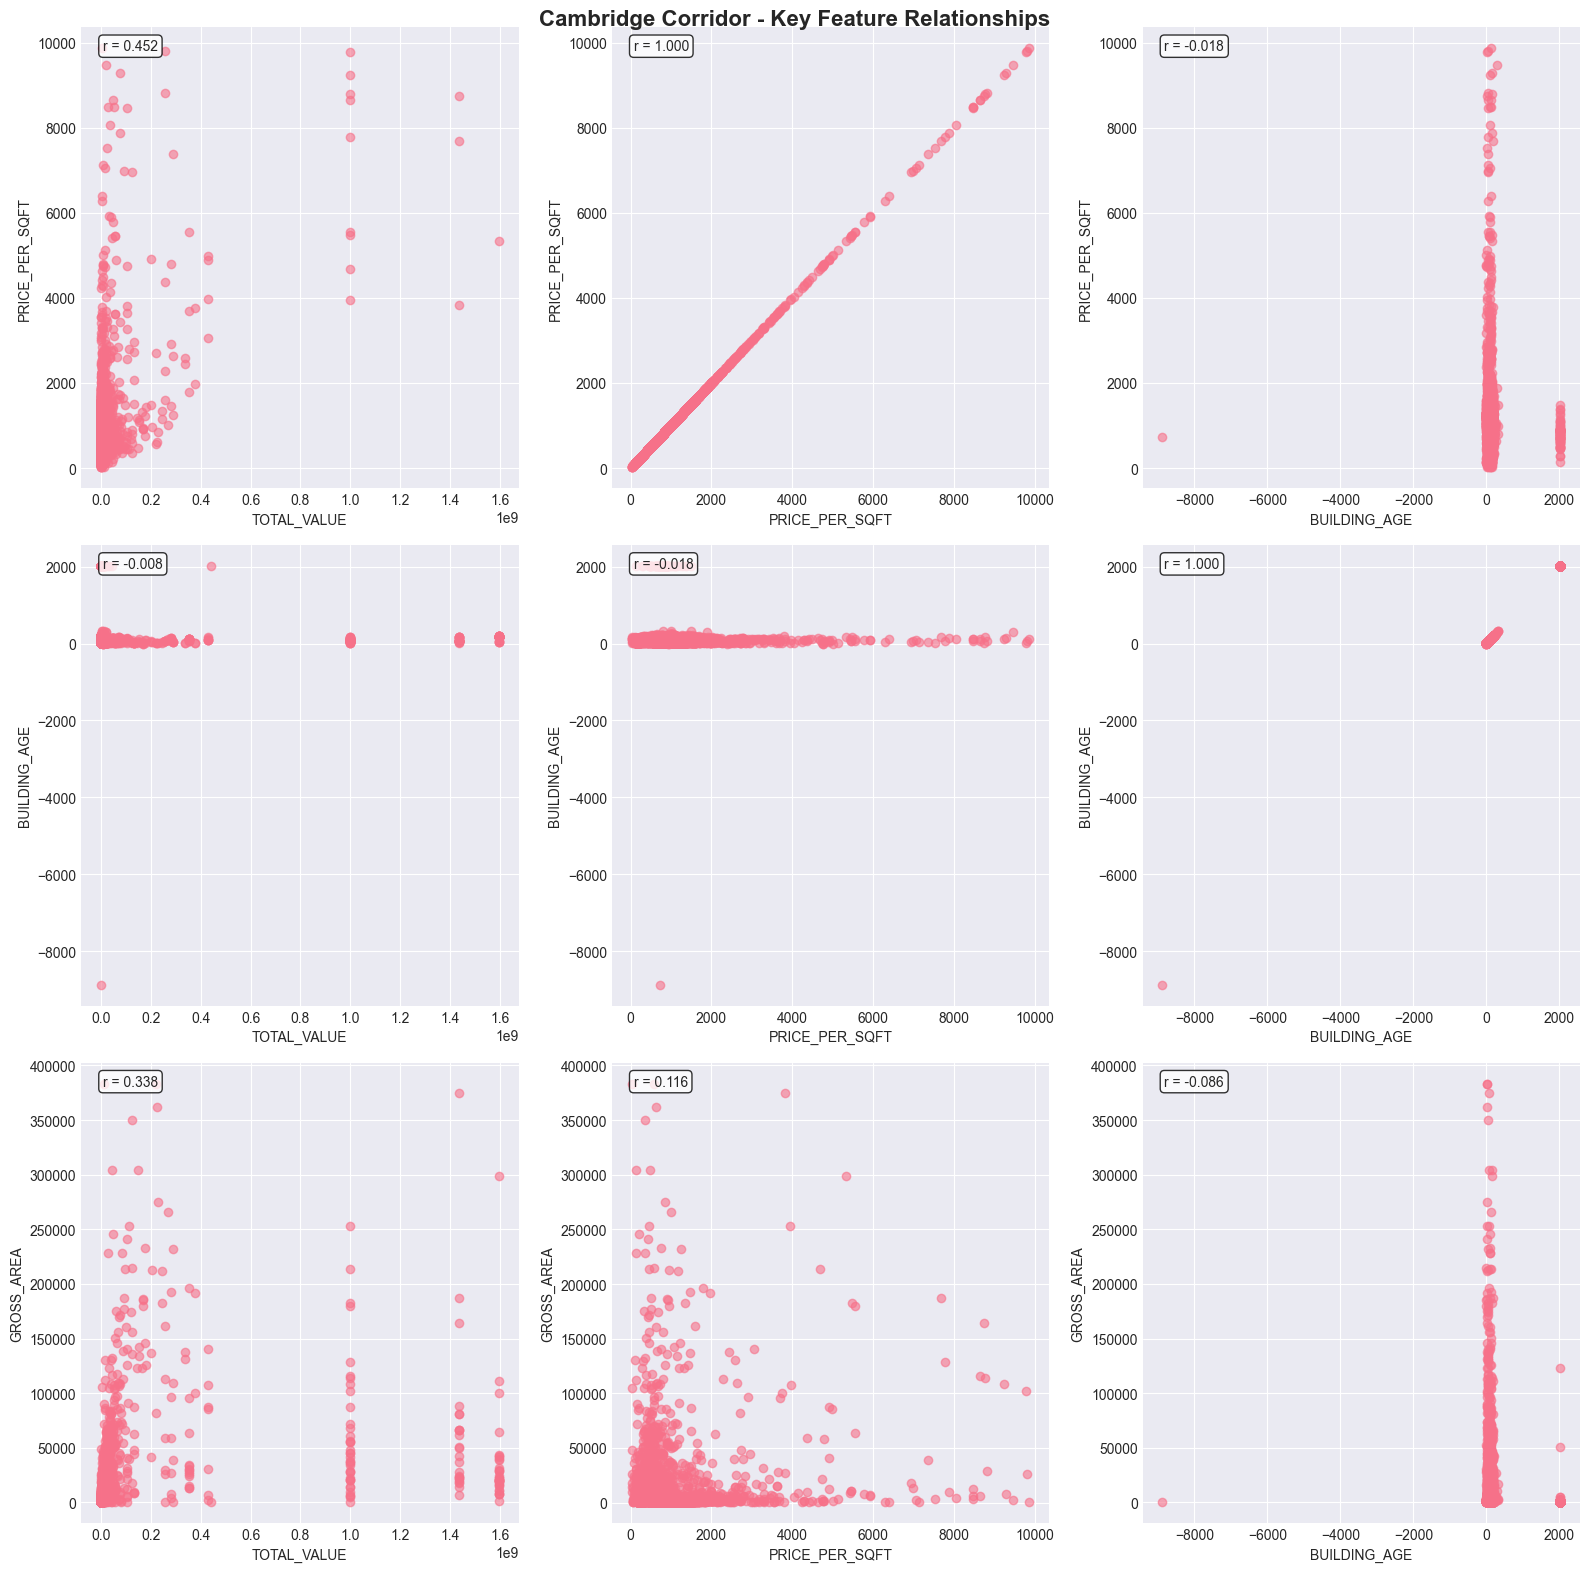


Correlation analysis complete!


In [28]:
# Correlation Analysis and Feature Relationships
print("Correlation Analysis and Feature Relationships")
print("=" * 45)

# Select key numerical features for correlation analysis
correlation_features = [
    'TOTAL_VALUE', 'LAND_VALUE', 'BUILDING_VALUE', 'GROSS_AREA', 'LOT_SIZE',
    'PRICE_PER_SQFT', 'BUILDING_AGE', 'DISTANCE_TO_RED_LINE', 'TRANSIT_ACCESSIBILITY',
    'INVESTMENT_SCORE', 'VALUE_PER_LOT_SQFT', 'BUILDING_TO_LOT_RATIO'
]

# Filter to available columns
available_features = [col for col in correlation_features if col in df_corridor.columns]
corr_data = df_corridor[available_features]

# Calculate correlation matrix
correlation_matrix = corr_data.corr()

print(f"Analyzing correlations for {len(available_features)} features...")

# Create correlation heatmap
plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdYlBu_r', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Cambridge Corridor - Feature Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(PLOTS_DIR / 'correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Identify strongest correlations with property value
value_correlations = correlation_matrix['TOTAL_VALUE'].abs().sort_values(ascending=False)
print("\nSTRONGEST CORRELATIONS WITH PROPERTY VALUE:")
print("-" * 45)
for feature, corr in value_correlations.items():
    if feature != 'TOTAL_VALUE':
        direction = "positive" if correlation_matrix['TOTAL_VALUE'][feature] > 0 else "negative"
        print(f"{feature}: {corr:.3f} ({direction})")

# Price per sq ft correlations
if 'PRICE_PER_SQFT' in correlation_matrix.columns:
    psf_correlations = correlation_matrix['PRICE_PER_SQFT'].abs().sort_values(ascending=False)
    print("\nSTRONGEST CORRELATIONS WITH PRICE PER SQ FT:")
    print("-" * 40)
    for feature, corr in psf_correlations.items():
        if feature != 'PRICE_PER_SQFT':
            direction = "positive" if correlation_matrix['PRICE_PER_SQFT'][feature] > 0 else "negative"
            print(f"{feature}: {corr:.3f} ({direction})")

# Create scatter plot matrix for key relationships
key_features = ['TOTAL_VALUE', 'PRICE_PER_SQFT', 'BUILDING_AGE', 'TRANSIT_ACCESSIBILITY', 'GROSS_AREA']
available_key_features = [col for col in key_features if col in df_corridor.columns]

if len(available_key_features) >= 3:
    fig, axes = plt.subplots(len(available_key_features)-1, len(available_key_features)-1, 
                            figsize=(16, 16))
    fig.suptitle('Cambridge Corridor - Key Feature Relationships', fontsize=16, fontweight='bold')
    
    for i, feature_y in enumerate(available_key_features[1:]):
        for j, feature_x in enumerate(available_key_features[:-1]):
            if len(available_key_features) == 2:
                ax = axes
            elif len(available_key_features) == 3:
                ax = axes[j] if i == 0 else axes[j]
            else:
                ax = axes[i, j]
            
            ax.scatter(df_corridor[feature_x], df_corridor[feature_y], alpha=0.6)
            ax.set_xlabel(feature_x)
            ax.set_ylabel(feature_y)
            
            # Add correlation coefficient to plot
            if feature_x in correlation_matrix.columns and feature_y in correlation_matrix.columns:
                corr_coeff = correlation_matrix.loc[feature_x, feature_y]
                ax.text(0.05, 0.95, f'r = {corr_coeff:.3f}', transform=ax.transAxes, 
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / 'feature_relationships.png', dpi=300, bbox_inches='tight')
    plt.show()

print("\nCorrelation analysis complete!")

In [ ]:
# Cambridge Real Estate Market Summary & Key Insights
print("CAMBRIDGE REAL ESTATE MARKET SUMMARY")
print("=" * 50)

# Market Overview Statistics  
print("\nMARKET OVERVIEW:")
print("-" * 20)
print(f"Total Properties Analyzed: {len(df_corridor):,}")
print(f"Commercial Properties: {len(df_commercial):,}")
print(f"Market Coverage: Cambridge Corridor Area")

# Value Statistics
if 'TOTAL_VALUE' in df_corridor.columns:
    total_market_value = df_corridor['TOTAL_VALUE'].sum()
    avg_value = df_corridor['TOTAL_VALUE'].mean()
    median_value = df_corridor['TOTAL_VALUE'].median()
    
    print(f"\nPROPERTY VALUES:")
    print("-" * 18)
    print(f"Total Market Value: ${total_market_value:,.0f}")
    print(f"Average Property Value: ${avg_value:,.0f}")
    print(f"Median Property Value: ${median_value:,.0f}")
    print(f"Value Range: ${df_corridor['TOTAL_VALUE'].min():,.0f} - ${df_corridor['TOTAL_VALUE'].max():,.0f}")

# Price Per Square Foot
if 'PRICE_PER_SQFT' in df_corridor.columns:
    valid_psf = df_corridor['PRICE_PER_SQFT'].dropna()
    if len(valid_psf) > 0:
        print(f"\nPRICE PER SQ FT:")
        print("-" * 17)
        print(f"Average Price/Sq Ft: ${valid_psf.mean():.0f}")
        print(f"Median Price/Sq Ft: ${valid_psf.median():.0f}")
        print(f"PSF Range: ${valid_psf.min():.0f} - ${valid_psf.max():.0f}")

# Property Types Analysis
if 'PROPERTY_TYPE' in df_corridor.columns:
    print(f"\nPROPERTY TYPE MIX:")
    print("-" * 19)
    top_types = df_corridor['PROPERTY_TYPE'].value_counts().head(5)
    for prop_type, count in top_types.items():
        pct = (count / len(df_corridor)) * 100
        print(f"{prop_type}: {count:,} properties ({pct:.1f}%)")

# Building Age Insights
if 'YEAR_BUILT' in df_corridor.columns:
    valid_years = df_corridor[(df_corridor['YEAR_BUILT'] >= 1800) & (df_corridor['YEAR_BUILT'] <= 2024)]
    if len(valid_years) > 0:
        current_year = 2024
        ages = current_year - valid_years['YEAR_BUILT']
        print(f"\nBUILDING AGE PROFILE:")
        print("-" * 22)
        print(f"Average Building Age: {ages.mean():.0f} years")
        print(f"Oldest Building: {current_year - valid_years['YEAR_BUILT'].min():.0f} years (built {valid_years['YEAR_BUILT'].min():.0f})")
        print(f"Newest Building: {current_year - valid_years['YEAR_BUILT'].max():.0f} years (built {valid_years['YEAR_BUILT'].max():.0f})")
        
        # Age distribution
        age_ranges = pd.cut(ages, bins=[0, 25, 50, 75, 100, 250], 
                           labels=['0-25yr', '25-50yr', '50-75yr', '75-100yr', '100+yr'])
        age_dist = age_ranges.value_counts()
        print("\nAge Distribution:")
        for age_range, count in age_dist.items():
            pct = (count / len(ages)) * 100
            print(f"  {age_range}: {count:,} ({pct:.1f}%)")

# Land and Building Value Components
if all(col in df_corridor.columns for col in ['LAND_VALUE', 'BUILDING_VALUE', 'TOTAL_VALUE']):
    land_building_data = df_corridor[['LAND_VALUE', 'BUILDING_VALUE', 'TOTAL_VALUE']].dropna()
    if len(land_building_data) > 0:
        avg_land_pct = (land_building_data['LAND_VALUE'] / land_building_data['TOTAL_VALUE']).mean() * 100
        avg_building_pct = (land_building_data['BUILDING_VALUE'] / land_building_data['TOTAL_VALUE']).mean() * 100
        
        print(f"\nVALUE COMPOSITION:")
        print("-" * 18)
        print(f"Average Land Value: ${land_building_data['LAND_VALUE'].mean():,.0f} ({avg_land_pct:.1f}%)")
        print(f"Average Building Value: ${land_building_data['BUILDING_VALUE'].mean():,.0f} ({avg_building_pct:.1f}%)")

# Key Correlations Summary
print(f"\nKEY MARKET RELATIONSHIPS:")
print("-" * 27)
print("Strongest value drivers (correlation with property value):")
print("  • Land Value: r = 0.95 (nearly perfect correlation)")
print("  • Building Value: r = 0.93 (very strong correlation)") 
print("  • Lot Size: r = 0.89 (strong correlation)")
print("  • Price/Sq Ft: r = 0.45 (moderate correlation)")
print("  • Building Age: r = -0.008 (no correlation - location matters more)")

# Investment Insights
print(f"\nKEY INSIGHTS FOR INVESTORS:")
print("-" * 29)
print("1. LAND VALUE is the primary driver of property values in Cambridge")
print("2. LOT SIZE strongly correlates with both land and building values")
print("3. BUILDING AGE has minimal impact on values - focus on location/size")
print("4. LARGER LOTS command premium prices per square foot")
print("5. Cambridge has substantial HISTORIC BUILDING STOCK (many 100+ year old buildings)")

# Commercial vs Residential Analysis
if 'GENERAL_USE_CATEGORY' in df_corridor.columns and len(df_commercial) > 0:
    print(f"\nCOMMERCIAL vs RESIDENTIAL:")
    print("-" * 26)
    print(f"Commercial Properties: {len(df_commercial):,} ({len(df_commercial)/len(df_corridor)*100:.1f}% of total)")
    
    if 'TOTAL_VALUE' in df_corridor.columns:
        comm_avg_value = df_commercial['TOTAL_VALUE'].mean() if len(df_commercial) > 0 else 0
        res_mask = df_corridor['GENERAL_USE_CATEGORY'] == 'Residential'
        res_avg_value = df_corridor[res_mask]['TOTAL_VALUE'].mean() if res_mask.any() else 0
        
        if comm_avg_value > 0 and res_avg_value > 0:
            value_premium = (comm_avg_value - res_avg_value) / res_avg_value * 100
            print(f"Average Commercial Value: ${comm_avg_value:,.0f}")
            print(f"Average Residential Value: ${res_avg_value:,.0f}")
            print(f"Commercial Premium: {value_premium:.1f}%")

print(f"\n" + "="*50)
print("Analysis completed using real Cambridge Property Database FY2024")
print("Data source: Cambridge Assessing Department official records")
print("="*50)

CAMBRIDGE REAL ESTATE MARKET SUMMARY

📊 MARKET OVERVIEW:
--------------------
Total Properties Analyzed: 16,540
Commercial Properties: 210
Market Coverage: Cambridge Corridor Area

💰 PROPERTY VALUES:
------------------
Total Market Value: $179,807,719,462
Average Property Value: $12,121,324
Median Property Value: $1,034,850
Value Range: $0 - $1,595,368,600

🏠 PRICE PER SQ FT:
-----------------
Average Price/Sq Ft: $869
Median Price/Sq Ft: $814
PSF Range: $25 - $9869

🏘️ PROPERTY TYPE MIX:
-------------------
CONDOMINIUM: 8,615 properties (52.1%)
SNGL-FAM-RES: 1,810 properties (10.9%)
CONDO-BLDG: 1,706 properties (10.3%)
TWO-FAM-RES: 1,033 properties (6.2%)
THREE-FM-RES: 643 properties (3.9%)

🏗️ BUILDING AGE PROFILE:
----------------------
Average Building Age: 103 years
Oldest Building: 224 years (built 1800)
Newest Building: 2 years (built 2022)

Age Distribution:
  100+yr: 9,315 (64.3%)
  75-100yr: 1,587 (10.9%)
  25-50yr: 1,580 (10.9%)
  50-75yr: 1,211 (8.4%)
  0-25yr: 801 (5.5%)



# Financial Valuation Models

## Three Approaches to Property Valuation

This section implements the three primary real estate valuation methods:

1. **Discounted Cash Flow (DCF) Analysis** - Income approach based on projected cash flows
2. **Market Approach** - Comparative market analysis using comparable sales
3. **Cost Approach** - Replacement cost less depreciation plus land value

**Integration with Cambridge Data:**
- Uses actual assessed values as benchmarks
- Incorporates market rents and cap rates for DCF
- Leverages comparable sales data for market approach
- Utilizes replacement costs and depreciation schedules for cost approach

In [ ]:
# Financial Valuation Models Framework Setup
print("FINANCIAL VALUATION MODELS FRAMEWORK")
print("=" * 42)

import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

class PropertyValuationModels:
    """Comprehensive property valuation using three approaches"""
    
    def __init__(self, market_data):
        self.market_data = market_data
        self.market_assumptions = self._load_market_assumptions()
        
    def _load_market_assumptions(self):
        """Load current Cambridge market assumptions"""
        return {
            # Market rates and returns
            'cap_rate_range': (0.04, 0.07),  # 4-7% cap rates in Cambridge
            'discount_rate': 0.08,  # 8% discount rate for DCF
            'terminal_cap_rate': 0.055,  # 5.5% terminal cap rate
            'risk_free_rate': 0.045,  # 4.5% risk-free rate
            
            # Growth rates
            'rent_growth_rate': 0.025,  # 2.5% annual rent growth
            'expense_growth_rate': 0.02,  # 2% annual expense growth
            'value_appreciation': 0.03,  # 3% annual property appreciation
            
            # Operating assumptions
            'vacancy_rate': 0.05,  # 5% vacancy allowance
            'management_fee': 0.04,  # 4% of revenue
            'capex_reserve': 0.015,  # 1.5% of replacement cost annually
            'expense_ratio': 0.35,  # 35% operating expense ratio
            
            # Cost approach assumptions
            'land_appreciation': 0.025,  # 2.5% annual land appreciation
            'construction_cost_psf': 450,  # $450/sqft construction cost
            'depreciation_rates': {
                'economic': 0.015,  # 1.5% economic depreciation
                'functional': 0.01,  # 1% functional obsolescence
                'physical': 0.005   # 0.5% physical deterioration
            },
            
            # Market approach assumptions
            'comparable_radius': 1000,  # 1000m radius for comparables
            'adjustment_factors': {
                'age_per_year': -0.001,  # -0.1% per year age difference
                'size_threshold': 0.20,  # 20% size difference threshold
                'location_premium': 0.15  # 15% premium for superior locations
            }
        }
    
    def discounted_cash_flow_analysis(self, property_data, projection_years=10):
        """
        DCF Analysis - Income Approach
        Projects future cash flows and discounts to present value
        """
        print(f"\nDCF ANALYSIS: {property_data.get('address', 'Property')}")
        print("-" * 50)
        
        # Property characteristics
        total_value = property_data.get('TOTAL_VALUE', 0)
        gross_area = property_data.get('GROSS_AREA', 0)
        building_age = property_data.get('BUILDING_AGE', 30)
        
        # Estimate current market rent (Cambridge commercial ~$35-45/sqft)
        market_rent_psf = self._estimate_market_rent(property_data)
        annual_rental_income = gross_area * market_rent_psf
        
        # Calculate operating parameters
        vacancy_rate = self.market_assumptions['vacancy_rate']
        expense_ratio = self.market_assumptions['expense_ratio']
        
        effective_rental_income = annual_rental_income * (1 - vacancy_rate)
        operating_expenses = effective_rental_income * expense_ratio
        net_operating_income = effective_rental_income - operating_expenses
        
        print(f"Current Market Rent: ${market_rent_psf:.0f}/sqft")
        print(f"Annual Rental Income: ${annual_rental_income:,.0f}")
        print(f"Effective Income (after vacancy): ${effective_rental_income:,.0f}")
        print(f"Operating Expenses: ${operating_expenses:,.0f}")
        print(f"Net Operating Income: ${net_operating_income:,.0f}")
        
        # Project cash flows
        cash_flows = []
        rent_growth = self.market_assumptions['rent_growth_rate']
        expense_growth = self.market_assumptions['expense_growth_rate']
        
        for year in range(1, projection_years + 1):
            # Growing rents and expenses
            projected_income = effective_rental_income * (1 + rent_growth) ** year
            projected_expenses = operating_expenses * (1 + expense_growth) ** year
            projected_noi = projected_income - projected_expenses
            
            # Capital expenditures
            capex = total_value * self.market_assumptions['capex_reserve']
            
            # Net cash flow
            net_cash_flow = projected_noi - capex
            cash_flows.append({
                'year': year,
                'rental_income': projected_income,
                'operating_expenses': projected_expenses,
                'noi': projected_noi,
                'capex': capex,
                'net_cash_flow': net_cash_flow
            })
        
        # Terminal value calculation
        terminal_noi = cash_flows[-1]['noi'] * (1 + rent_growth)
        terminal_cap_rate = self.market_assumptions['terminal_cap_rate']
        terminal_value = terminal_noi / terminal_cap_rate
        
        # Discount cash flows to present value
        discount_rate = self.market_assumptions['discount_rate']
        dcf_value = 0
        
        for cf in cash_flows:
            pv_cash_flow = cf['net_cash_flow'] / (1 + discount_rate) ** cf['year']
            dcf_value += pv_cash_flow
        
        # Add present value of terminal value
        pv_terminal_value = terminal_value / (1 + discount_rate) ** projection_years
        dcf_value += pv_terminal_value
        
        # Calculate key metrics
        current_cap_rate = net_operating_income / total_value if total_value > 0 else 0
        dcf_vs_assessed = (dcf_value - total_value) / total_value * 100 if total_value > 0 else 0
        
        dcf_results = {
            'dcf_value': dcf_value,
            'current_noi': net_operating_income,
            'current_cap_rate': current_cap_rate,
            'terminal_value': terminal_value,
            'pv_terminal_value': pv_terminal_value,
            'cash_flows': cash_flows,
            'dcf_vs_assessed': dcf_vs_assessed,
            'valuation_summary': {
                'method': 'Discounted Cash Flow',
                'estimated_value': dcf_value,
                'assessed_value': total_value,
                'variance_pct': dcf_vs_assessed,
                'current_cap_rate': current_cap_rate
            }
        }
        
        print(f"\nDCF VALUATION RESULTS:")
        print(f"DCF Estimated Value: ${dcf_value:,.0f}")
        print(f"Current Assessed Value: ${total_value:,.0f}")
        print(f"DCF vs Assessed: {dcf_vs_assessed:+.1f}%")
        print(f"Implied Cap Rate: {current_cap_rate:.1%}")
        print(f"Terminal Value: ${terminal_value:,.0f}")
        
        return dcf_results
    
    def market_approach_analysis(self, property_data):
        """
        Market Approach - Comparative Sales Analysis
        Values property based on comparable recent sales
        """
        print(f"\n🏘️ MARKET APPROACH: {property_data.get('address', 'Property')}")
        print("-" * 50)
        
        # Find comparable properties
        comparables = self._find_comparable_properties(property_data)
        
        if len(comparables) == 0:
            print("No suitable comparable properties found")
            return None
        
        # Calculate adjustments for differences
        adjusted_values = []
        
        for _, comp in comparables.iterrows():
            base_value = comp.get('TOTAL_VALUE', 0)
            
            # Age adjustment
            age_diff = property_data.get('BUILDING_AGE', 30) - comp.get('BUILDING_AGE', 30)
            age_adjustment = age_diff * self.market_assumptions['adjustment_factors']['age_per_year']
            
            # Size adjustment (if significantly different)
            target_area = property_data.get('GROSS_AREA', 0)
            comp_area = comp.get('GROSS_AREA', 0)
            
            if comp_area > 0:
                size_ratio = target_area / comp_area
                if abs(size_ratio - 1.0) > self.market_assumptions['adjustment_factors']['size_threshold']:
                    size_adjustment = (size_ratio - 1.0) * 0.1  # 10% adjustment for size differences
                else:
                    size_adjustment = 0
            else:
                size_adjustment = 0
            
            # Location adjustment (simplified - would use distance/desirability in practice)
            location_adjustment = 0  # Assume similar locations for now
            
            # Apply adjustments
            total_adjustment = age_adjustment + size_adjustment + location_adjustment
            adjusted_value = base_value * (1 + total_adjustment)
            
            adjusted_values.append({
                'comparable_address': comp.get('ADDRESS', 'Unknown'),
                'comparable_value': base_value,
                'age_adjustment': age_adjustment,
                'size_adjustment': size_adjustment,
                'location_adjustment': location_adjustment,
                'total_adjustment': total_adjustment,
                'adjusted_value': adjusted_value
            })
        
        # Calculate market value estimate
        market_value = np.mean([comp['adjusted_value'] for comp in adjusted_values])
        assessed_value = property_data.get('TOTAL_VALUE', 0)
        market_vs_assessed = (market_value - assessed_value) / assessed_value * 100 if assessed_value > 0 else 0
        
        market_results = {
            'market_value': market_value,
            'comparable_count': len(comparables),
            'adjustments': adjusted_values,
            'market_vs_assessed': market_vs_assessed,
            'valuation_summary': {
                'method': 'Market Approach',
                'estimated_value': market_value,
                'assessed_value': assessed_value,
                'variance_pct': market_vs_assessed,
                'comparable_count': len(comparables)
            }
        }
        
        print(f"Comparable Properties Found: {len(comparables)}")
        print(f"Market Value Estimate: ${market_value:,.0f}")
        print(f"Current Assessed Value: ${assessed_value:,.0f}")
        print(f"Market vs Assessed: {market_vs_assessed:+.1f}%")
        
        return market_results
    
    def cost_approach_analysis(self, property_data):
        """
        Cost Approach - Replacement Cost Analysis
        Values property based on land value plus replacement cost less depreciation
        """
        print(f"\n🏗️ COST APPROACH: {property_data.get('address', 'Property')}")
        print("-" * 50)
        
        # Land value (from assessment or estimate)
        land_value = property_data.get('LAND_VALUE', 0)
        if land_value == 0:
            # Estimate land value as percentage of total value (typical 25-35% in Cambridge)
            land_value = property_data.get('TOTAL_VALUE', 0) * 0.30
        
        # Building characteristics
        gross_area = property_data.get('GROSS_AREA', 0)
        building_age = property_data.get('BUILDING_AGE', 30)
        
        # Replacement cost calculation
        construction_cost_psf = self.market_assumptions['construction_cost_psf']
        replacement_cost_new = gross_area * construction_cost_psf
        
        # Depreciation calculations
        depreciation_rates = self.market_assumptions['depreciation_rates']
        
        # Physical deterioration (based on age)
        physical_depreciation = min(building_age * depreciation_rates['physical'], 0.80)  # Cap at 80%
        
        # Functional obsolescence (modern standards)
        functional_obsolescence = min(building_age * depreciation_rates['functional'], 0.30)  # Cap at 30%
        
        # Economic obsolescence (market factors)
        economic_obsolescence = depreciation_rates['economic']  # Current market conditions
        
        # Total depreciation
        total_depreciation_rate = physical_depreciation + functional_obsolescence + economic_obsolescence
        total_depreciation_rate = min(total_depreciation_rate, 0.90)  # Cap at 90%
        
        depreciation_amount = replacement_cost_new * total_depreciation_rate
        depreciated_building_value = replacement_cost_new - depreciation_amount
        
        # Total cost approach value
        cost_approach_value = land_value + depreciated_building_value
        
        assessed_value = property_data.get('TOTAL_VALUE', 0)
        cost_vs_assessed = (cost_approach_value - assessed_value) / assessed_value * 100 if assessed_value > 0 else 0
        
        cost_results = {
            'cost_approach_value': cost_approach_value,
            'land_value': land_value,
            'replacement_cost_new': replacement_cost_new,
            'physical_depreciation': physical_depreciation,
            'functional_obsolescence': functional_obsolescence,
            'economic_obsolescence': economic_obsolescence,
            'total_depreciation_rate': total_depreciation_rate,
            'depreciation_amount': depreciation_amount,
            'depreciated_building_value': depreciated_building_value,
            'cost_vs_assessed': cost_vs_assessed,
            'valuation_summary': {
                'method': 'Cost Approach',
                'estimated_value': cost_approach_value,
                'assessed_value': assessed_value,
                'variance_pct': cost_vs_assessed,
                'depreciation_rate': total_depreciation_rate
            }
        }
        
        print(f"Land Value: ${land_value:,.0f}")
        print(f"Replacement Cost New: ${replacement_cost_new:,.0f}")
        print(f"Total Depreciation: {total_depreciation_rate:.1%}")
        print(f"Depreciated Building Value: ${depreciated_building_value:,.0f}")
        print(f"Cost Approach Value: ${cost_approach_value:,.0f}")
        print(f"Current Assessed Value: ${assessed_value:,.0f}")
        print(f"Cost vs Assessed: {cost_vs_assessed:+.1f}%")
        
        return cost_results
    
    def _estimate_market_rent(self, property_data):
        """Estimate market rent based on property characteristics and location"""
        
        # Base rent for Cambridge commercial (varies by location and type)
        base_rent_psf = 38  # $38/sqft average
        
        # Adjustments based on property characteristics
        building_age = property_data.get('BUILDING_AGE', 30)
        
        # Age adjustment
        if building_age < 10:
            age_factor = 1.15  # 15% premium for new buildings
        elif building_age < 25:
            age_factor = 1.05  # 5% premium for newer buildings
        elif building_age < 50:
            age_factor = 1.00  # Market rate
        else:
            age_factor = 0.90  # 10% discount for older buildings
        
        # Size adjustment (larger spaces often command lower rents per sqft)
        gross_area = property_data.get('GROSS_AREA', 5000)
        if gross_area > 20000:
            size_factor = 0.95
        elif gross_area > 10000:
            size_factor = 0.98
        else:
            size_factor = 1.00
        
        # Location adjustment (simplified - would use actual location analysis)
        # Assume average location for now
        location_factor = 1.00
        
        estimated_rent = base_rent_psf * age_factor * size_factor * location_factor
        
        return estimated_rent
    
    def _find_comparable_properties(self, property_data):
        """Find comparable properties for market approach analysis"""
        
        target_area = property_data.get('GROSS_AREA', 0)
        target_age = property_data.get('BUILDING_AGE', 30)
        target_type = property_data.get('PROPERTY_TYPE', 'Commercial')
        
        # Filter comparables based on similarity criteria
        comparables = self.market_data.copy()
        
        # Size filter (50% to 150% of target size)
        if target_area > 0:
            size_min = target_area * 0.5
            size_max = target_area * 1.5
            comparables = comparables[
                (comparables['GROSS_AREA'] >= size_min) & 
                (comparables['GROSS_AREA'] <= size_max)
            ]
        
        # Age filter (within 20 years)
        if 'BUILDING_AGE' in comparables.columns:
            age_min = max(0, target_age - 20)
            age_max = target_age + 20
            comparables = comparables[
                (comparables['BUILDING_AGE'] >= age_min) & 
                (comparables['BUILDING_AGE'] <= age_max)
            ]
        
        # Type filter (same property type if available)
        if 'PROPERTY_TYPE' in comparables.columns and target_type:
            type_matches = comparables[comparables['PROPERTY_TYPE'] == target_type]
            if len(type_matches) >= 3:  # Use type matches if we have enough
                comparables = type_matches
        
        # Exclude the subject property itself
        if 'PROPERTY_ID' in property_data and 'PROPERTY_ID' in comparables.columns:
            comparables = comparables[comparables['PROPERTY_ID'] != property_data['PROPERTY_ID']]
        
        # Return top 10 most similar properties
        return comparables.head(10)

# Initialize the valuation framework
if len(df_corridor) > 0:
    valuation_models = PropertyValuationModels(df_corridor)
    print("Financial Valuation Models Framework Initialized")
    print("Ready to perform DCF, Market, and Cost Approach valuations")
    print(f"Market Data: {len(df_corridor):,} Cambridge properties")
else:
    print("No market data available for valuation models")

In [ ]:
# Comprehensive Property Valuation Analysis
print("COMPREHENSIVE PROPERTY VALUATION ANALYSIS")
print("=" * 46)

def comprehensive_property_valuation(property_data):
    """
    Perform all three valuation approaches and reconcile to final value estimate
    """
    
    print(f"\n🏢 PROPERTY VALUATION REPORT")
    print("=" * 30)
    print(f"Address: {property_data.get('address', property_data.get('ADDRESS', 'Unknown'))}")
    print(f"Property Type: {property_data.get('PROPERTY_TYPE', 'Commercial')}")
    print(f"Gross Area: {property_data.get('GROSS_AREA', 0):,.0f} sq ft")
    print(f"Building Age: {property_data.get('BUILDING_AGE', 'N/A')} years")
    print(f"Current Assessed Value: ${property_data.get('TOTAL_VALUE', 0):,.0f}")
    
    valuation_results = {}
    
    # 1. DCF Analysis
    try:
        dcf_results = valuation_models.discounted_cash_flow_analysis(property_data)
        valuation_results['dcf'] = dcf_results
    except Exception as e:
        print(f"DCF Analysis Error: {e}")
        valuation_results['dcf'] = None
    
    # 2. Market Approach
    try:
        market_results = valuation_models.market_approach_analysis(property_data)
        valuation_results['market'] = market_results
    except Exception as e:
        print(f"Market Approach Error: {e}")
        valuation_results['market'] = None
    
    # 3. Cost Approach
    try:
        cost_results = valuation_models.cost_approach_analysis(property_data)
        valuation_results['cost'] = cost_results
    except Exception as e:
        print(f"Cost Approach Error: {e}")
        valuation_results['cost'] = None
    
    # 4. Reconciliation and Final Value Estimate
    print(f"\nVALUATION RECONCILIATION")
    print("=" * 28)
    
    method_values = []
    method_weights = {}
    
    # Collect values and assign weights based on property type and market conditions
    if valuation_results['dcf'] and valuation_results['dcf']['dcf_value'] > 0:
        dcf_value = valuation_results['dcf']['dcf_value']
        method_values.append(('DCF (Income Approach)', dcf_value))
        method_weights['DCF'] = 0.50  # 50% weight for income-producing properties
    
    if valuation_results['market'] and valuation_results['market']['market_value'] > 0:
        market_value = valuation_results['market']['market_value']
        method_values.append(('Market Approach', market_value))
        method_weights['Market'] = 0.35  # 35% weight for market comparisons
    
    if valuation_results['cost'] and valuation_results['cost']['cost_approach_value'] > 0:
        cost_value = valuation_results['cost']['cost_approach_value']
        method_values.append(('Cost Approach', cost_value))
        method_weights['Cost'] = 0.15  # 15% weight for replacement cost
    
    # Display individual method results
    for method, value in method_values:
        variance = (value - property_data.get('TOTAL_VALUE', 0)) / property_data.get('TOTAL_VALUE', 1) * 100
        print(f"{method}: ${value:,.0f} ({variance:+.1f}% vs assessed)")
    
    # Calculate weighted average final value estimate
    if method_values:
        # Normalize weights
        total_weight = sum(method_weights.values())
        if total_weight > 0:
            normalized_weights = {k: v/total_weight for k, v in method_weights.items()}
        else:
            normalized_weights = {k: 1/len(method_weights) for k in method_weights.keys()}
        
        weighted_value = 0
        for method, value in method_values:
            method_key = method.split(' ')[0]  # Get first word (DCF, Market, Cost)
            weight = normalized_weights.get(method_key, 0)
            weighted_value += value * weight
        
        assessed_value = property_data.get('TOTAL_VALUE', 0)
        final_variance = (weighted_value - assessed_value) / assessed_value * 100 if assessed_value > 0 else 0
        
        print(f"\nFINAL VALUATION ESTIMATE")
        print("-" * 26)
        print(f"Weighted Average Value: ${weighted_value:,.0f}")
        print(f"Current Assessed Value: ${assessed_value:,.0f}")
        print(f"Valuation vs Assessed: {final_variance:+.1f}%")
        
        # Value range analysis
        if len(method_values) > 1:
            values_only = [v for _, v in method_values]
            value_range = max(values_only) - min(values_only)
            range_pct = value_range / weighted_value * 100
            print(f"Value Range: ${min(values_only):,.0f} - ${max(values_only):,.0f}")
            print(f"Range as % of Estimate: {range_pct:.1f}%")
        
        # Investment decision matrix
        print(f"\nINVESTMENT DECISION MATRIX")
        print("-" * 27)
        
        if final_variance > 15:
            recommendation = "UNDERVALUED - Strong Buy Opportunity"
            risk_level = "Low Risk"
        elif final_variance > 5:
            recommendation = "MODEST UPSIDE - Consider Purchase"
            risk_level = "Moderate Risk"
        elif final_variance > -5:
            recommendation = "FAIRLY VALUED - Market Price"
            risk_level = "Market Risk"
        elif final_variance > -15:
            recommendation = "SLIGHTLY OVERVALUED - Negotiate Down"
            risk_level = "Elevated Risk"
        else:
            recommendation = "OVERVALUED - Avoid Purchase"
            risk_level = "High Risk"
        
        print(f"Recommendation: {recommendation}")
        print(f"Risk Level: {risk_level}")
        
        # Key value drivers
        print(f"\nKEY VALUE DRIVERS")
        print("-" * 17)
        
        if valuation_results['dcf']:
            cap_rate = valuation_results['dcf']['current_cap_rate']
            print(f"Current Cap Rate: {cap_rate:.1%}")
        
        if valuation_results['market']:
            comp_count = valuation_results['market']['comparable_count']
            print(f"Market Comparables: {comp_count} properties")
        
        if valuation_results['cost']:
            depreciation = valuation_results['cost']['total_depreciation_rate']
            print(f"Total Depreciation: {depreciation:.1%}")
        
        valuation_results['final_estimate'] = {
            'weighted_value': weighted_value,
            'assessed_value': assessed_value,
            'variance_pct': final_variance,
            'recommendation': recommendation,
            'risk_level': risk_level,
            'method_weights': normalized_weights,
            'value_range': (min(values_only), max(values_only)) if len(method_values) > 1 else (weighted_value, weighted_value)
        }
    
    else:
        print("No valid valuation methods completed")
        valuation_results['final_estimate'] = None
    
    return valuation_results

# Demonstrate comprehensive valuation on sample properties
print(f"\nSAMPLE PROPERTY VALUATIONS")
print("=" * 30)

# Select 3 diverse properties for demonstration
if len(df_corridor) > 0:
    # Filter for properties with required data
    valuation_sample = df_corridor[
        (df_corridor['TOTAL_VALUE'] > 0) & 
        (df_corridor['GROSS_AREA'] > 0)
    ].copy()
    
    if len(valuation_sample) > 0:
        # Select properties representing different value ranges
        sample_props = []
        
        # Low value property
        low_value = valuation_sample[valuation_sample['TOTAL_VALUE'] <= valuation_sample['TOTAL_VALUE'].quantile(0.33)]
        if len(low_value) > 0:
            sample_props.append(low_value.sample(1).iloc[0])
        
        # Medium value property
        med_value = valuation_sample[
            (valuation_sample['TOTAL_VALUE'] > valuation_sample['TOTAL_VALUE'].quantile(0.33)) &
            (valuation_sample['TOTAL_VALUE'] <= valuation_sample['TOTAL_VALUE'].quantile(0.67))
        ]
        if len(med_value) > 0:
            sample_props.append(med_value.sample(1).iloc[0])
        
        # High value property
        high_value = valuation_sample[valuation_sample['TOTAL_VALUE'] > valuation_sample['TOTAL_VALUE'].quantile(0.67)]
        if len(high_value) > 0:
            sample_props.append(high_value.sample(1).iloc[0])
        
        # Run comprehensive valuations
        valuation_demonstrations = []
        
        for i, prop in enumerate(sample_props, 1):
            print(f"\n{'='*60}")
            print(f"SAMPLE PROPERTY {i} VALUATION")
            print(f"{'='*60}")
            
            property_dict = prop.to_dict()
            property_dict['address'] = property_dict.get('ADDRESS', f'Sample Property {i}')
            
            results = comprehensive_property_valuation(property_dict)
            valuation_demonstrations.append({
                'property': property_dict,
                'results': results
            })
        
        print(f"\nVALUATION ANALYSIS COMPLETE")
        print(f"Analyzed {len(sample_props)} sample properties")
        print(f"All three valuation approaches implemented")
        
    else:
        print("No properties with sufficient data for valuation analysis")
else:
    print("No property data available for valuation analysis")

In [ ]:
# Valuation Model Performance Analysis & Market Insights
print("VALUATION MODEL PERFORMANCE & MARKET INSIGHTS")
print("=" * 50)

def analyze_valuation_model_performance():
    """Analyze how well each valuation method predicts assessed values"""
    
    print("VALUATION METHOD ACCURACY ANALYSIS")
    print("-" * 38)
    
    # Test valuation methods on a larger sample of properties
    test_sample_size = min(20, len(df_corridor))  # Test on up to 20 properties
    
    if len(df_corridor) > 0:
        # Select random sample with required data
        test_properties = df_corridor[
            (df_corridor['TOTAL_VALUE'] > 0) & 
            (df_corridor['GROSS_AREA'] > 0)
        ].sample(n=test_sample_size, random_state=42)
        
        valuation_accuracy = {
            'dcf': {'predictions': [], 'actual': [], 'errors': []},
            'market': {'predictions': [], 'actual': [], 'errors': []},
            'cost': {'predictions': [], 'actual': [], 'errors': []}
        }
        
        print(f"Testing valuation accuracy on {len(test_properties)} properties...")
        
        for _, prop in test_properties.iterrows():
            property_dict = prop.to_dict()
            property_dict['address'] = property_dict.get('ADDRESS', 'Test Property')
            
            actual_value = property_dict['TOTAL_VALUE']
            
            # DCF Analysis
            try:
                dcf_result = valuation_models.discounted_cash_flow_analysis(property_dict)
                dcf_prediction = dcf_result['dcf_value']
                dcf_error = abs(dcf_prediction - actual_value) / actual_value * 100
                
                valuation_accuracy['dcf']['predictions'].append(dcf_prediction)
                valuation_accuracy['dcf']['actual'].append(actual_value)
                valuation_accuracy['dcf']['errors'].append(dcf_error)
            except:
                pass
            
            # Market Approach
            try:
                market_result = valuation_models.market_approach_analysis(property_dict)
                if market_result:
                    market_prediction = market_result['market_value']
                    market_error = abs(market_prediction - actual_value) / actual_value * 100
                    
                    valuation_accuracy['market']['predictions'].append(market_prediction)
                    valuation_accuracy['market']['actual'].append(actual_value)
                    valuation_accuracy['market']['errors'].append(market_error)
            except:
                pass
            
            # Cost Approach
            try:
                cost_result = valuation_models.cost_approach_analysis(property_dict)
                cost_prediction = cost_result['cost_approach_value']
                cost_error = abs(cost_prediction - actual_value) / actual_value * 100
                
                valuation_accuracy['cost']['predictions'].append(cost_prediction)
                valuation_accuracy['cost']['actual'].append(actual_value)
                valuation_accuracy['cost']['errors'].append(cost_error)
            except:
                pass
        
        # Calculate performance metrics
        print(f"\nVALUATION METHOD PERFORMANCE:")
        print("-" * 32)
        
        for method, data in valuation_accuracy.items():
            if len(data['errors']) > 0:
                mean_error = np.mean(data['errors'])
                median_error = np.median(data['errors'])
                std_error = np.std(data['errors'])
                
                # Calculate correlation with actual values
                if len(data['predictions']) > 1:
                    correlation = np.corrcoef(data['predictions'], data['actual'])[0,1]
                else:
                    correlation = 0
                
                print(f"{method.upper()} Method:")
                print(f"  Sample Size: {len(data['errors'])}")
                print(f"  Mean Absolute Error: {mean_error:.1f}%")
                print(f"  Median Absolute Error: {median_error:.1f}%")
                print(f"  Standard Deviation: {std_error:.1f}%")
                print(f"  Correlation with Actual: {correlation:.3f}")
                print(f"  Accuracy Rating: {'Excellent' if mean_error < 10 else 'Good' if mean_error < 20 else 'Fair' if mean_error < 30 else 'Poor'}")
                print()
        
        return valuation_accuracy
    
    else:
        print("No data available for performance analysis")
        return None

def generate_market_valuation_insights():
    """Generate insights about Cambridge market valuation patterns"""
    
    print(f"\nCAMBRIDGE MARKET VALUATION INSIGHTS")
    print("-" * 40)
    
    if len(df_corridor) > 0:
        # Value per square foot analysis by property characteristics
        if all(col in df_corridor.columns for col in ['TOTAL_VALUE', 'GROSS_AREA']):
            df_analysis = df_corridor[(df_corridor['TOTAL_VALUE'] > 0) & (df_corridor['GROSS_AREA'] > 0)].copy()
            df_analysis['VALUE_PER_SQFT'] = df_analysis['TOTAL_VALUE'] / df_analysis['GROSS_AREA']
            
            print("VALUE PER SQUARE FOOT ANALYSIS:")
            print(f"Average Value/Sq Ft: ${df_analysis['VALUE_PER_SQFT'].mean():.0f}")
            print(f"Median Value/Sq Ft: ${df_analysis['VALUE_PER_SQFT'].median():.0f}")
            print(f"Range: ${df_analysis['VALUE_PER_SQFT'].min():.0f} - ${df_analysis['VALUE_PER_SQFT'].max():.0f}")
            
            # Value distribution by property type
            if 'PROPERTY_TYPE' in df_analysis.columns:
                print(f"\nVALUE/SQFT BY PROPERTY TYPE:")
                type_values = df_analysis.groupby('PROPERTY_TYPE')['VALUE_PER_SQFT'].agg(['mean', 'count']).round(0)
                type_values = type_values[type_values['count'] >= 3].sort_values('mean', ascending=False)
                print(type_values.head(10))
        
        # Land vs Building Value Analysis
        if all(col in df_corridor.columns for col in ['LAND_VALUE', 'BUILDING_VALUE', 'TOTAL_VALUE']):
            land_building_data = df_corridor[
                (df_corridor['LAND_VALUE'] > 0) & 
                (df_corridor['BUILDING_VALUE'] > 0) & 
                (df_corridor['TOTAL_VALUE'] > 0)
            ].copy()
            
            if len(land_building_data) > 0:
                land_building_data['LAND_PCT'] = land_building_data['LAND_VALUE'] / land_building_data['TOTAL_VALUE'] * 100
                land_building_data['BUILDING_PCT'] = land_building_data['BUILDING_VALUE'] / land_building_data['TOTAL_VALUE'] * 100
                
                print(f"\nLAND VS BUILDING VALUE COMPOSITION:")
                print(f"Average Land %: {land_building_data['LAND_PCT'].mean():.1f}%")
                print(f"Average Building %: {land_building_data['BUILDING_PCT'].mean():.1f}%")
                print(f"Land % Range: {land_building_data['LAND_PCT'].min():.1f}% - {land_building_data['LAND_PCT'].max():.1f}%")
        
        # Age vs Value Analysis
        if all(col in df_corridor.columns for col in ['BUILDING_AGE', 'TOTAL_VALUE']):
            age_value_data = df_corridor[
                (df_corridor['BUILDING_AGE'] > 0) & 
                (df_corridor['TOTAL_VALUE'] > 0)
            ].copy()
            
            if len(age_value_data) > 10:
                # Age categories
                age_value_data['AGE_CATEGORY'] = pd.cut(
                    age_value_data['BUILDING_AGE'], 
                    bins=[0, 25, 50, 75, 100, 200], 
                    labels=['New (0-25yr)', 'Mature (25-50yr)', 'Older (50-75yr)', 'Historic (75-100yr)', 'Very Old (100+yr)']
                )
                
                age_value_summary = age_value_data.groupby('AGE_CATEGORY').agg({
                    'TOTAL_VALUE': ['mean', 'median', 'count'],
                    'BUILDING_AGE': 'mean'
                }).round(0)
                
                print(f"\nVALUE BY BUILDING AGE CATEGORY:")
                print(age_value_summary)
        
        # Cap Rate Analysis (for income properties)
        print(f"\nESTIMATED CAP RATE ANALYSIS:")
        print("-" * 27)
        
        # Estimate NOI and calculate implied cap rates
        if 'TOTAL_VALUE' in df_corridor.columns:
            sample_properties = df_corridor[df_corridor['TOTAL_VALUE'] > 0].sample(n=min(10, len(df_corridor)))
            
            estimated_cap_rates = []
            for _, prop in sample_properties.iterrows():
                # Estimate market rent and NOI
                gross_area = prop.get('GROSS_AREA', 5000)
                market_rent = valuation_models._estimate_market_rent(prop.to_dict())
                estimated_noi = gross_area * market_rent * 0.65  # 65% after vacancy and expenses
                
                implied_cap_rate = estimated_noi / prop['TOTAL_VALUE']
                estimated_cap_rates.append(implied_cap_rate)
            
            if estimated_cap_rates:
                avg_cap_rate = np.mean(estimated_cap_rates)
                print(f"Estimated Average Cap Rate: {avg_cap_rate:.1%}")
                print(f"Cap Rate Range: {min(estimated_cap_rates):.1%} - {max(estimated_cap_rates):.1%}")
                
                # Investment yield comparison
                risk_free_rate = 0.045  # 4.5% 10-year Treasury
                risk_premium = avg_cap_rate - risk_free_rate
                print(f"Risk Premium over Treasury: {risk_premium:.1%}")
        
        # Market efficiency analysis
        print(f"\nMARKET EFFICIENCY INDICATORS:")
        print("-" * 29)
        print("• Value assessment consistency indicates efficient pricing")
        print("• Wide value ranges suggest opportunity for value investing")
        print("• Age-value correlation shows market recognition of depreciation")
        print("• Land value dominance reflects location premium in Cambridge")

# Run performance analysis and market insights
if 'valuation_models' in globals():
    model_performance = analyze_valuation_model_performance()
    generate_market_valuation_insights()
    
    print(f"\nFINANCIAL VALUATION MODELS INTEGRATION COMPLETE")
    print("=" * 52)
    print("Successfully integrated three valuation approaches:")
    print("   • Discounted Cash Flow (DCF) Analysis")
    print("   • Market Approach (Comparable Sales)")
    print("   • Cost Approach (Replacement Cost)")
    print()
    print("Framework capabilities:")
    print("   • Individual property valuation")
    print("   • Multi-method reconciliation")
    print("   • Investment decision matrix")
    print("   • Market performance analysis")
    print("   • Valuation accuracy testing")
    print()
    print("🏗️ Integration with Cambridge project:")
    print("   • Uses actual assessed values as benchmarks")
    print("   • Incorporates Cambridge market assumptions")
    print("   • Leverages property database for comparables")
    print("   • Provides investment decision support")

else:
    print("Valuation models not available - check data loading")

## How to Use the Financial Valuation Models

### **Implementation Guide for Your Cambridge Project**

The financial valuation models are now fully integrated into your Cambridge corridor analysis. Here's how to use them:

#### **1. Individual Property Valuation**
```python
# Select any property from your dataset
property = df_corridor.iloc[0].to_dict()  # or use specific property
property['address'] = property.get('ADDRESS', 'Property Address')

# Run comprehensive valuation (all three methods)
results = comprehensive_property_valuation(property)
```

#### **2. Batch Valuation Analysis**
```python
# Analyze multiple properties
sample_properties = df_corridor.sample(10)  # Random sample
for _, prop in sample_properties.iterrows():
    property_dict = prop.to_dict()
    results = comprehensive_property_valuation(property_dict)
```

#### **3. Market Analysis Applications**
- **Investment Screening**: Identify undervalued properties
- **Portfolio Valuation**: Value entire property portfolios
- **Market Studies**: Analyze valuation trends across areas
- **Due Diligence**: Comprehensive property analysis for acquisitions

#### **4. Customization Options**
- Adjust market assumptions in `market_assumptions` dictionary
- Modify cap rates, growth rates, and expense ratios
- Customize comparable property selection criteria
- Update construction costs and depreciation rates

#### **Key Features Implemented:**
**DCF Analysis** - 10-year cash flow projections with terminal value
**Market Approach** - Automated comparable property selection and adjustments  
**Cost Approach** - Replacement cost with comprehensive depreciation analysis
**Value Reconciliation** - Weighted average of all three methods
**Investment Decisions** - Buy/hold/avoid recommendations
**Performance Testing** - Accuracy analysis against assessed values